In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [18]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    return model

def build_cgan_generator(z_dim):
    z = Input(shape=(z_dim,))
    label = Input(shape=(1, ), dtype='int32')
    
    label_emebedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_emebedding = Flatten()(label_emebedding)
    
    joined_representation = Multiply()([z, label_emebedding])
    
    generator = build_generator(z_dim)
    conditional_img = generator(joined_representation)
    
    return Model([z, label], conditional_img)

In [19]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', 
                     input_shape=(img_shape[0], img_shape[1], img_shape[2]+1)))
    model.add(LeakyReLU(alpha=0.01))
              
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
              
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_cgan_discriminator(img_shape):
    img = Input(shape=img_shape)
    label = Input(shape=(1, ), dtype='int32')
    
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)
    
    return Model([img, label], classification)

In [20]:
def build_cgan(generator, discriminator):
    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ))
    
    img = generator([z, label])
    classification = discriminator([img, label])
    
    model = Model([z, label], classification)
    
    return model

In [21]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)

discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [23]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))

        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            sample_images()

In [24]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([z, labels])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

100 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.000008]
200 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.000009]
300 [D loss: 0.201883, acc.: 90.62%] [G loss: 4.613676]
400 [D loss: 0.001822, acc.: 100.00%] [G loss: 0.042586]
500 [D loss: 0.004037, acc.: 100.00%] [G loss: 0.163830]
600 [D loss: 0.001434, acc.: 100.00%] [G loss: 0.021234]
700 [D loss: 0.006400, acc.: 100.00%] [G loss: 8.198212]
800 [D loss: 0.019399, acc.: 100.00%] [G loss: 4.626709]
900 [D loss: 0.004095, acc.: 100.00%] [G loss: 3.010572]
1000 [D loss: 0.001587, acc.: 100.00%] [G loss: 0.519482]


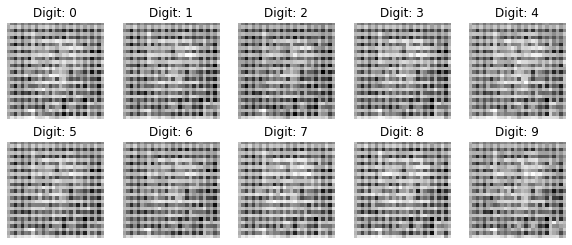

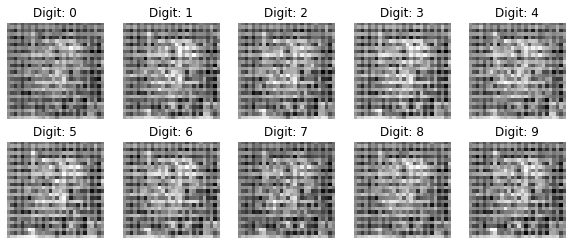

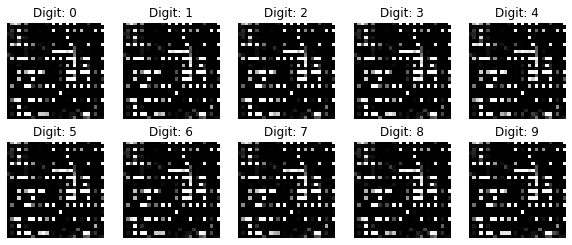

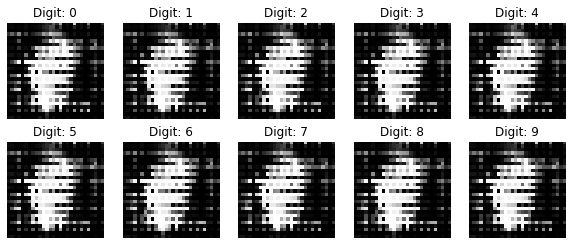

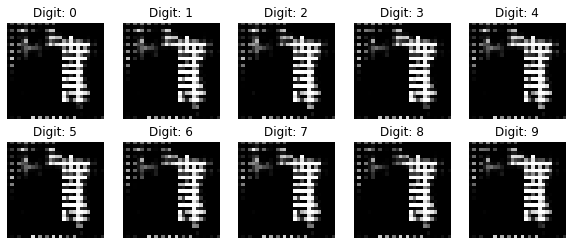

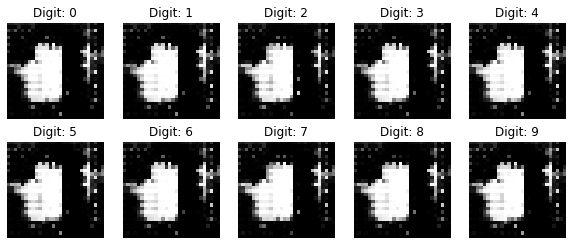

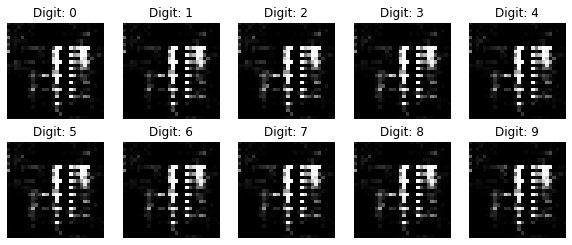

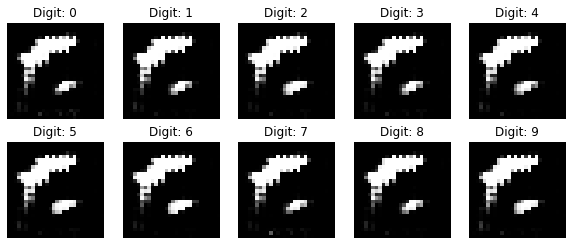

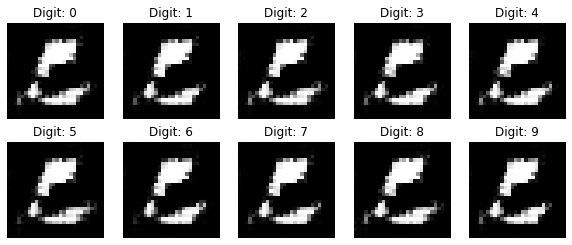

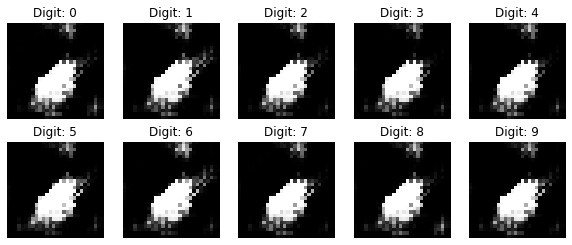

In [27]:
# Set hyperparameters
iterations = 1000
batch_size = 32
sample_interval = 100

train(iterations, batch_size, sample_interval)

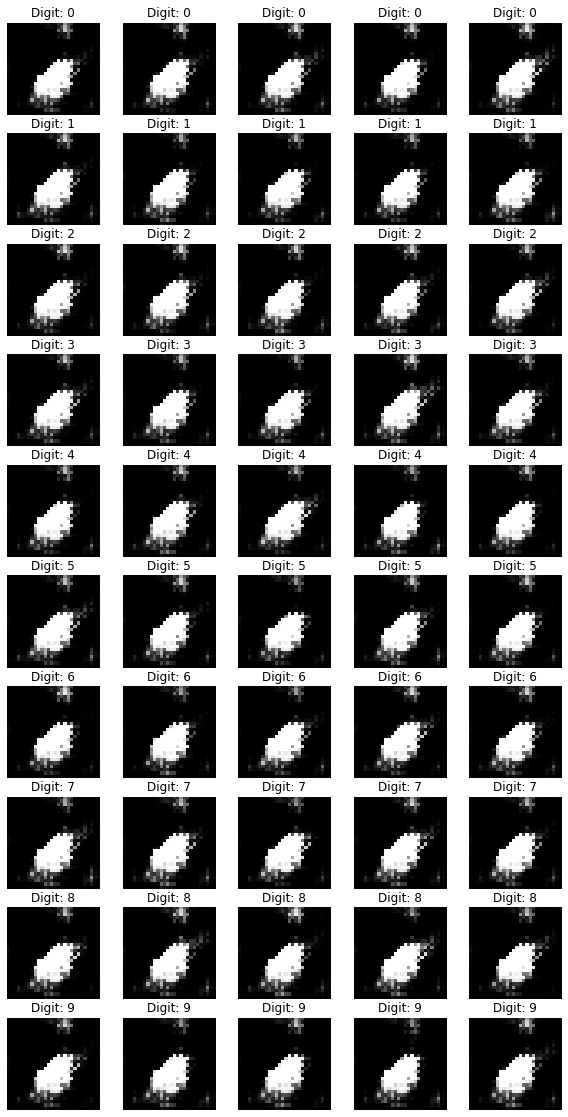

In [28]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1